# Geothermal Datathon 2021
---

<img src="../figures/the_roaring_kitties_logo.png" width="200" align="center">

Team members:
- **Ricardo Lara**
- **Artur Davletshin**
- **Aigul Akberova**
- **Sercan Gul**
- **Hakki Aydin**
- **Jose Hernandez**


---

### Import Modules

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

### Define functions

In [137]:
def interpolate_syn_temp(df_original, df_synthetic):
    df = df_original.copy(deep=True)
    df_syn = df_synthetic.copy(deep=True)

    df['Synthetic Temp, C'] = np.NAN

    UWIs = df_syn.UWI.unique()
    
    for i, UWI in enumerate(UWIs):
        try:
            x = df.loc[df.UWI == UWI, 'Depth subsea, m'][0]
        except KeyError:
            continue

        depths = df_syn.loc[df_syn.UWI == UWI,'Depth subsea, m'].to_list()
        temps = df_syn.loc[df_syn.UWI == UWI,'Synthetic Temp, C'].to_list()

        if x < depths[-1]:
            x1 = max([d for d in depths if d < x])
            x2 = min([d for d in depths if d > x])
            t1 = temps[depths.index(x1)]
            t2 = temps[depths.index(x2)]
        else:
            x1 = depths[-2]
            x2 = depths[-1]
            t1 = temps[depths.index(x1)]
            t2 = temps[depths.index(x2)]
            
        t = t1 + (x - x1) * (t2 - t1) / (x2 - x1)
            
        df.loc[df.UWI == UWI, 'Synthetic Temp, C'] = t
    
    return df

def get_static_temp(df_original, df_static):
    df = df_original.copy(deep=True)
    df2 = df_static.copy(deep=True)

    df3 = df.merge(df2, on='UWI', how='left')

    df3['static_diff_depth'] = df3['Depth subsea, m'] - df3['Depth, m']

    df4 = df.merge(df3[['UWI', 'Static Temp, C', 'Depth, m']], on='UWI', how='left')

    return df4


def get_synthetic_temp(df_original, df_synthetic):
    df = df_original.copy(deep=True)
    df2 = df_synthetic.copy(deep=True)

    df3 = df.merge(df2, on='UWI', how='left')

    df3['syn_diff_depth'] = df3['Depth subsea, m_y'] - df3['Depth subsea, m_x']
    df3['diff_depth_abs'] = np.abs(df3['syn_diff_depth'])

    idx = df3.groupby(['UWI'])['diff_depth_abs'].transform(min) == df3['diff_depth_abs']

    truetemp = df3.loc[idx, ['UWI', 'Synthetic Temp, C']]

    df4 = df.merge(truetemp, on='UWI', how='left')

    return df4

def interpolate_static_temp(df_original, df_synthetic):
    df = df_original.copy(deep=True)
    df_syn = df_synthetic.copy(deep=True)

    df['Static Temp, C'] = np.NAN

    UWIs = df_syn.UWI.unique()
    
    for i, UWI in enumerate(UWIs):
        x = df.loc[df.UWI == UWI, 'MD, m_x'].values

        x1 = 0
        x2 = df_syn.loc[df_syn.UWI == UWI,'Depth, m'].values[0]
        t1 = 20
        t2 = df_syn.loc[df_syn.UWI == UWI,'Static Temp, C'].values[0]
            
        t = t1 + (x - x1) * (t2 - t1) / (x2 - x1)
            
        df.loc[df.UWI == UWI, 'Static Temp, C'] = t
    
    return x

In [138]:
dvtest = interpolate_static_temp(DVm, TL[TL.Field == 'Duvernay'])
# dvtest[dvtest['Synthetic Temp, C'].isnull()]
dvtest

array([nan])

In [139]:
DVm.columns.to_list()

['UWI',
 'Depth subsea, m',
 'MD, m_x',
 'Elev above sea, m',
 'BHT, C',
 'Formation',
 'Synthetic Temp, C',
 'Static Temp, C',
 'Depth, m',
 'True Temp, C',
 'source',
 'label',
 'KB Elev, m',
 'TVD, m',
 'MD, m_y',
 'DST BHT, C']

In [147]:
DVm.columns.to_list()

['UWI',
 'Depth subsea, m',
 'MD, m_x',
 'Elev above sea, m',
 'BHT, C',
 'Formation',
 'Synthetic Temp, C',
 'Static Temp, C',
 'Depth, m',
 'True Temp, C',
 'source',
 'label',
 'KB Elev, m',
 'TVD, m',
 'MD, m_y',
 'DST BHT, C']

In [148]:
DVm.loc[DVm.source=='static',['MD, m_x',
     'TVD, m',
     'MD, m_y',
     'Depth, m',
     'BHT, C',
     'DST BHT, C',
     'Static Temp, C']]

MD, m_x  TVD, m  MD, m_y     Depth, m  BHT, C  DST BHT, C  Static Temp, C
44   1805.90     NaN  1805.90  3074.517502   76.67       76.67      117.611111
47   1412.10     NaN  1412.10  2945.282306   48.89       48.89      111.055556
113  1454.65     NaN  1454.65  2529.839919   50.00       50.00       92.777778
138  2324.85     NaN  2324.85  1043.939967   77.78       77.78       95.000000
145  3095.00     NaN      NaN  3676.999793   84.00         NaN      117.000000
155  2485.80     NaN  2485.80  3307.079894   77.78       77.78      104.444444
206  1703.55     NaN  2098.40  2930.956706   54.44       73.89       90.555556
234  1588.35     NaN   722.85          NaN   54.44         NaN       60.000000
296  1457.25     NaN  1456.95  1371.599956   50.00       50.00       76.666667
302  1492.00     NaN  1492.00  1219.199961   48.89       48.89       61.666667
337  1581.60     NaN  1581.60  2743.199912   50.00       50.00      107.222222
355  1159.60     NaN  1159.60  2059.999878   43.33       43.33       84.700000
360  1678.65     NaN  1401.80  2962.655905   60.00         NaN       97.388889
364  1018.05     NaN  1018.05  1054.607966   37.78       37.78       42.222222
414  1463.20     NaN  1463.20  2377.439924   47.78       47.78       98.888889
423  1485.60     NaN  1485.60  3026.663903   62.78       62.78      111.833333
439  1608.00     NaN  1608.00   483.717585   50.56       50.56       63.000000
441  1723.30     NaN  1650.50  2923.641506   37.78       61.11      109.111111
455  2518.00     NaN  2518.00   796.137575   68.00       68.00       78.055556
478  1893.00     NaN  1893.00   800.099974   50.00       50.00       90.000000
487  2191.00     NaN  2191.00   937.259970   78.00       78.00      122.000000
503  1707.95     NaN  2124.90   975.359969   51.67       58.89      105.000000

In [140]:
DVm.isnull().sum()

UWI                    0
Depth subsea, m        0
MD, m_x                0
Elev above sea, m      0
BHT, C                 0
Formation              0
Synthetic Temp, C    140
Static Temp, C       490
Depth, m             491
True Temp, C         140
source               140
label                  0
KB Elev, m            30
TVD, m               479
MD, m_y               30
DST BHT, C           129
dtype: int64

In [112]:
dvtest['Static Temp, C'].notnull().sum()

0

# 1 Eaglebine

## 1.1 Load temperature data

In [75]:
EB = pd.read_excel('../data/Eaglebine/Eaglebine BHT TSC data for SPE April 21 2020.xlsx') # Bottom-hole temperatures
EB_syn = pd.read_excel('../data/Eaglebine/Eaglebine TrueTemp_Train2.xlsx') # Synthetic temperatures
TL = pd.read_csv('../data/Data_static_logs.csv') # Temperature static logs
assign = pd.read_csv("../data/set_assign.csv") # labels for train and validation sets

UWIs_test = assign.loc[assign.Set == 'Validation_Testing', 'UWI']
UWIs_train = assign.loc[assign.Set == 'Training', 'UWI']

### Convert unis to SI

In [76]:
# Eaglebine BHT
columns = ['TD (ft)', 'GL(ft)', 'BHT_below sea level (ft)', 'BHT_ subsurface (ft)']
EB[['TD, m', 'GL, m', 'Depth subsea, m', 'Depth subsurface, m',]]  = EB[columns] / 3.28084
EB['BHT, C'] = (EB['BHTorMRT (maximum recorded temperature) oF']-32)*5/9

# Eaglebine True
EB_syn['Depth subsea, m'] = EB_syn['Depth sub-sea (feet)'] / 3.28084
EB_syn['True Temperature, C'] = (EB_syn['True Temperature   (oF)'] - 32) * 5 / 9

# Log temps
TL['Depth, m'] = TL['Depth (ft)'] / 3.28084

### Rename columns

In [77]:
EB.columns.to_list()

['UWI',
 'SurfLat',
 'SurfLong',
 'TD (ft)',
 'GL(ft)',
 'BHT_below sea level (ft)',
 'BHT_ subsurface (ft)',
 'BHTorMRT (maximum recorded temperature) oF',
 'TSC or ORT (time since circulation or original recorded time in hours)',
 'TD, m',
 'GL, m',
 'Depth subsea, m',
 'Depth subsurface, m',
 'BHT, C']

In [78]:
# Rename columns
col_names = ['UWI',
                'SurfLat',
                'SurfLong',
                'TD, ft',
                'GL, ft',
                'Depth subsea, ft',
                'Depth subsurface, ft',
                'BHT, F',
                'TSC, h', 
                'TD, m',
                'GL, m',
                'Depth subsea, m',
                'Depth subsurface, m',
                'BHT, C'
                ]

EB.columns = col_names

# Select subset of features in SI units
EB2 = EB[['UWI',
        'SurfLat',
        'SurfLong',
        'TD, m',
        'GL, m',
        'Depth subsea, m',
        'Depth subsurface, m',
        'TSC, h',
        'BHT, C'
]]

In [79]:
EB_syn.columns.to_list()

['UWI',
 'Depth sub-sea (feet)',
 'True Temperature   (oF)',
 'Depth subsea, m',
 'True Temperature, C']

In [80]:
col_names = ['UWI',
            'Depth subsea, ft',
            'Synthetic Temp, F',
            'Depth subsea, m',
            'Synthetic Temp, C']

EB_syn.columns = col_names

EB_syn2 = EB_syn[['UWI',
                'Depth subsea, m',
                'Synthetic Temp, C']]

In [81]:
TL.columns.to_list()

['Well_ID', 'Depth (ft)', 'Temp (degC)', 'Field', 'Depth, m']

In [82]:
col_names = ['UWI',
            'Depth, ft',
            'Static Temp, C',
            'Field',
            'Depth, m',
            ]

TL.columns = col_names

# Select subset of features in SI units
TL2 = TL[['UWI',
        'Depth, m',
        'Static Temp, C',
        'Field'
        ]]

In [83]:
EB2.UWI = EB2.UWI.astype('str');
EB_syn2.UWI = EB_syn2.UWI.astype('str');
TL2.UWI = TL2.UWI.astype('str');
assign.UWI = assign.UWI.astype('str');

c:\Users\rico\Documents\GitHub\GTX-2021\gtx_env\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


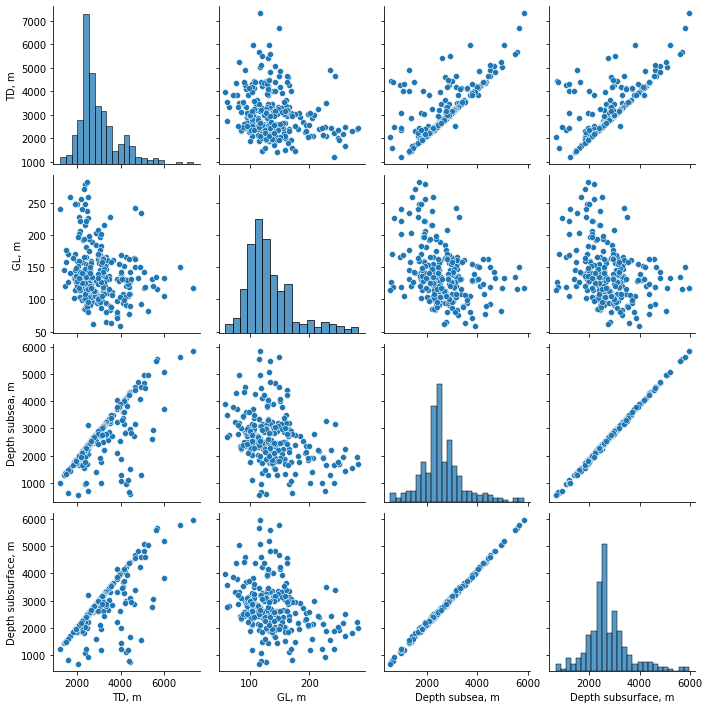

In [84]:
sns.pairplot(EB2[[      'TD, m',
        'GL, m',
        'Depth subsea, m',
        'Depth subsurface, m',]])

## 1.2 Add Synthetic and Static Temperatures

In [85]:
EB3 = interpolate_syn_temp(EB2, EB_syn2)
EB3.head()

UWI    SurfLat   SurfLong        TD, m       GL, m  \
0  42013301410000  28.690426 -98.470138  5982.919009  105.430317   
1  42013301930000  28.779921 -98.208313  3284.219895  121.127516   
2  42013302760000  28.994360 -98.421799  1880.006340  140.329916   
3  42013305480000  28.759118 -98.156410  2498.750320  125.089916   
4  42013310190000  28.817400 -98.155319  3352.799893  155.118811   

   Depth subsea, m  Depth subsurface, m  TSC, h      BHT, C  Synthetic Temp, C  
0      3725.417881          3830.848197    5.50   61.666667         141.773056  
1      3168.700699          3289.828215   11.00  107.222222                NaN  
2      1747.418344          1887.748260    5.50   65.555556                NaN  
3      2379.268724          2504.358640    5.00   76.666667                NaN  
4      3203.289401          3358.408213    7.75   98.888889                NaN

In [86]:
EB4 = EB3.merge(TL2[['UWI','Static Temp, C']], on='UWI', how='left')
EB4.head()

UWI    SurfLat   SurfLong        TD, m       GL, m  \
0  42013301410000  28.690426 -98.470138  5982.919009  105.430317   
1  42013301930000  28.779921 -98.208313  3284.219895  121.127516   
2  42013302760000  28.994360 -98.421799  1880.006340  140.329916   
3  42013305480000  28.759118 -98.156410  2498.750320  125.089916   
4  42013310190000  28.817400 -98.155319  3352.799893  155.118811   

   Depth subsea, m  Depth subsurface, m  TSC, h      BHT, C  \
0      3725.417881          3830.848197    5.50   61.666667   
1      3168.700699          3289.828215   11.00  107.222222   
2      1747.418344          1887.748260    5.50   65.555556   
3      2379.268724          2504.358640    5.00   76.666667   
4      3203.289401          3358.408213    7.75   98.888889   

   Synthetic Temp, C  Static Temp, C  
0         141.773056             NaN  
1                NaN         132.778  
2                NaN             NaN  
3                NaN             NaN  
4                NaN             NaN

## 1.3 Merge Synthetic and Static Temperatures


In [87]:
EB4["True Temp, C"] =  EB4["Static Temp, C"].fillna(EB4['Synthetic Temp, C'])
EB4["source"] = np.NAN
EB4.loc[EB4['Synthetic Temp, C'].notnull(), 'source'] = 'synthetic'
EB4.loc[EB4['Static Temp, C'].notnull(), 'source'] = 'static'
EB4.head(50)

UWI    SurfLat   SurfLong        TD, m       GL, m  \
0  42013301410000  28.690426 -98.470138  5982.919009  105.430317   
1  42013301930000  28.779921 -98.208313  3284.219895  121.127516   
2  42013302760000  28.994360 -98.421799  1880.006340  140.329916   
3  42013305480000  28.759118 -98.156410  2498.750320  125.089916   
4  42013310190000  28.817400 -98.155319  3352.799893  155.118811   
5  42013311740000  28.819071 -98.151352  3339.388693  160.913059   
6  42013312950000  28.927915 -98.577467  2022.957535  158.922715   
7  42013313140000  28.694047 -98.765861  2612.745516  130.881116   
8  42013313780000  28.851271 -98.771820  2221.382329  157.322515   
9  42013325590000  28.987249 -98.701927  1610.258348  170.200315   

   Depth subsea, m  Depth subsurface, m  TSC, h      BHT, C  \
0      3725.417881          3830.848197    5.50   61.666667   
1      3168.700699          3289.828215   11.00  107.222222   
2      1747.418344          1887.748260    5.50   65.555556   
3      2379.268724          2504.358640    5.00   76.666667   
4      3203.289401          3358.408213    7.75   98.888889   
5      3151.775155          3312.688214    9.00  118.333333   
6      1879.701540          2038.624255    3.00   62.777778   
7      2484.729520          2615.610636    8.00   85.000000   
8      1880.692140          2038.014655    7.00   65.000000   
9       626.363980           796.564295    1.00   37.777778   

   Synthetic Temp, C  Static Temp, C  True Temp, C     source  
0         141.773056             NaN    141.773056  synthetic  
1                NaN         132.778    132.778000     static  
2                NaN             NaN           NaN        NaN  
3                NaN             NaN           NaN        NaN  
4                NaN             NaN           NaN        NaN  
5                NaN             NaN           NaN        NaN  
6                NaN             NaN           NaN        NaN  
7                NaN             NaN           NaN        NaN  
8                NaN             NaN           NaN        NaN  
9                NaN             NaN           NaN        NaN

In [88]:
EB4['label'] = 'not assigned'
EB4.loc[EB4.UWI.isin(UWIs_test), 'label'] = 'test'
EB4.loc[EB4.UWI.isin(UWIs_train), 'label'] = 'train'
EB4.head()

UWI    SurfLat   SurfLong        TD, m       GL, m  \
0  42013301410000  28.690426 -98.470138  5982.919009  105.430317   
1  42013301930000  28.779921 -98.208313  3284.219895  121.127516   
2  42013302760000  28.994360 -98.421799  1880.006340  140.329916   
3  42013305480000  28.759118 -98.156410  2498.750320  125.089916   
4  42013310190000  28.817400 -98.155319  3352.799893  155.118811   

   Depth subsea, m  Depth subsurface, m  TSC, h      BHT, C  \
0      3725.417881          3830.848197    5.50   61.666667   
1      3168.700699          3289.828215   11.00  107.222222   
2      1747.418344          1887.748260    5.50   65.555556   
3      2379.268724          2504.358640    5.00   76.666667   
4      3203.289401          3358.408213    7.75   98.888889   

   Synthetic Temp, C  Static Temp, C  True Temp, C     source  label  
0         141.773056             NaN    141.773056  synthetic  train  
1                NaN         132.778    132.778000     static  train  
2                NaN             NaN           NaN        NaN  train  
3                NaN             NaN           NaN        NaN  train  
4                NaN             NaN           NaN        NaN  train

In [25]:
EB4.to_csv('tidy data/Eaglebine_Temperatures.csv', index=False)

In [73]:
EB4.to_csv('Eaglebine.csv', index=False)

In [89]:
EB4['True Temp, C'].isnull().sum()

304

In [90]:
EB4.head(100)

UWI    SurfLat   SurfLong        TD, m       GL, m  \
0   42013301410000  28.690426 -98.470138  5982.919009  105.430317   
1   42013301930000  28.779921 -98.208313  3284.219895  121.127516   
2   42013302760000  28.994360 -98.421799  1880.006340  140.329916   
3   42013305480000  28.759118 -98.156410  2498.750320  125.089916   
4   42013310190000  28.817400 -98.155319  3352.799893  155.118811   
..             ...        ...        ...          ...         ...   
95  42051315180000  30.523190 -96.594727  2634.386316  116.860316   
96  42051315190000  30.548019 -96.650337  2458.516721  134.538716   
97  42051315580000  30.562047 -96.558226  2598.724717   91.561917   
98  42051315590000  30.402630 -96.794182  2516.428719  120.213116   
99  42051316070000  30.353781 -96.743843  2655.112715  103.449117   

    Depth subsea, m  Depth subsurface, m  TSC, h      BHT, C  \
0       3725.417881          3830.848197    5.50   61.666667   
1       3168.700699          3289.828215   11.00  107.222222   
2       1747.418344          1887.748260    5.50   65.555556   
3       2379.268724          2504.358640    5.00   76.666667   
4       3203.289401          3358.408213    7.75   98.888889   
..              ...                  ...     ...         ...   
95      2523.134319          2639.994636    8.00   89.444444   
96      2327.757526          2462.296241    5.00   60.000000   
97      2502.712720          2594.274637   20.50   85.555556   
98      2402.738323          2522.951439    5.00   78.888889   
99      2554.528718          2657.977835    6.00   92.222222   

    Synthetic Temp, C  Static Temp, C  True Temp, C     source  label  
0          141.773056             NaN    141.773056  synthetic  train  
1                 NaN         132.778    132.778000     static  train  
2                 NaN             NaN           NaN        NaN  train  
3                 NaN             NaN           NaN        NaN  train  
4                 NaN             NaN           NaN        NaN  train  
..                ...             ...           ...        ...    ...  
95                NaN             NaN           NaN        NaN  train  
96                NaN             NaN           NaN        NaN  train  
97                NaN             NaN           NaN        NaN  train  
98                NaN             NaN           NaN        NaN  train  
99                NaN             NaN           NaN        NaN   test  

[100 rows x 14 columns]

# 2 Duvernay

## 2.1 Load temperature data

In [28]:
DV = pd.read_excel('../data/Duvernay/Duvernay DST BHT for SPE April 20 2021.xlsx')
DV_syn = pd.read_excel('../data/Duvernay/Duvenay TrueTemp_Train.xlsx')
DV_dst = pd.read_csv('tidy data/Duvernay DST Temps.csv')

In [29]:
DV.columns

Index(['Well ID', 'DST Start Depth (MD) (m)', 'DST End Depth (MD) (m)',
       'DST Bottom Hole Temp. (degC)', 'DST Test Date', 'Test Type',
       'DST Misrun', 'DST Number', 'Formation DSTd', 'Unnamed: 9',
       'elevation M above sea level', 'UWI'],
      dtype='object')

In [37]:
#* add extra column 
DV['MD, m'] =  (DV['DST Start Depth (MD) (m)'] + DV['DST End Depth (MD) (m)'])/2

DV['Depth subsea, m']= - (DV['elevation M above sea level'] - DV['MD, m'])



In [38]:
columns = ['UWI',
        'Depth subsea, m',
        'MD, m',
        'elevation M above sea level',
        'DST Bottom Hole Temp. (degC)',
        'Formation DSTd',
]

DV2 = DV[columns]

col_names = ['UWI',
                'Depth subsea, m',
                'MD, m',
                'Elev above sea, m',
                'BHT, C',
                'Formation'
                ]

DV2.columns = col_names

In [39]:
DV_syn

UWI  Depths subsea (m)  True Temperature (oC)
0       100010107020W500               -720                   2.53
1       100010107020W500               -700                   2.54
2       100010107020W500               -680                   2.54
3       100010107020W500               -660                   3.30
4       100010107020W500               -640                   4.06
...                  ...                ...                    ...
331016  1S2011505522W400               1560                  86.62
331017  1S2011505522W400               1580                  87.36
331018  1S2011505522W400               1600                  88.10
331019  1S2011505522W400               1620                  88.84
331020  1S2011505522W400               1640                  88.75

[331021 rows x 3 columns]

In [40]:
column_names = ['UWI',
                'Depth subsea, m',
                'Synthetic Temp, C',
                ]

DV_syn.columns = column_names

In [43]:
DV2.UWI = DV2.UWI.astype('str');
DV_syn.UWI = DV_syn.UWI.astype('str');

## 2.2 Add Synthetic and Static Temperatures

In [44]:
DV3 = get_synthetic_temp(DV2, DV_syn)
DV3.head()

UWI  Depth subsea, m   MD, m  Elev above sea, m  BHT, C  \
0  100010107020W500            716.0  1417.0              701.0   48.33   
1  100010608109W500           1044.4  1690.0              645.6   34.26   
2  100010904012W500           2424.2  3708.0             1283.8  104.40   
3  100011206021W400            171.9   823.5              651.6   29.00   
4  100011506915W500            936.4  1809.5              873.1   64.00   

   Formation  Synthetic Temp, C  
0  TRmontney              60.97  
1    Dmuskeg              63.98  
2    Melkton                NaN  
3  Dwintrbrn              39.07  
4   Dwabamun              69.47

In [62]:
DV4 = get_static_temp(DV3, TL)
DV4.head()

UWI  Depth subsea, m   MD, m  Elev above sea, m  BHT, C  \
0  100010107020W500            716.0  1417.0              701.0   48.33   
1  100010608109W500           1044.4  1690.0              645.6   34.26   
2  100010904012W500           2424.2  3708.0             1283.8  104.40   
3  100011206021W400            171.9   823.5              651.6   29.00   
4  100011506915W500            936.4  1809.5              873.1   64.00   

   Formation  Synthetic Temp, C  Static Temp, C  Depth, m  
0  TRmontney              60.97             NaN       NaN  
1    Dmuskeg              63.98             NaN       NaN  
2    Melkton                NaN             NaN       NaN  
3  Dwintrbrn              39.07             NaN       NaN  
4   Dwabamun              69.47             NaN       NaN

In [63]:
DV4["True Temp, C"] =  DV4["Static Temp, C"].fillna(DV4['Synthetic Temp, C'])
DV4["source"] = np.NAN
DV4.loc[~DV4['Synthetic Temp, C'].isnull(), 'source'] = 'synthetic'
DV4.loc[~DV4['Static Temp, C'].isnull(), 'source'] = 'static'

In [64]:
DV4['label'] = 'not assigned'
DV4.loc[DV4.UWI.isin(UWIs_test), 'label'] = 'test'
DV4.loc[DV4.UWI.isin(UWIs_train), 'label'] = 'train'

In [65]:
DV4.to_csv('tidy data/Duvernay_Temperatures.csv', index=False)

## Check DST

In [66]:
DVm = DV4.merge(DV_dst[['UWI', 'KB Elev, m', 'TVD, m', 'MD, m', 'DST BHT, C']], on='UWI', how='left')

In [67]:
DVm[DVm.source == 'static'].sort_values('UWI')

UWI  Depth subsea, m  MD, m_x  Elev above sea, m  BHT, C  \
44   100022706319W500          1009.20  1805.90              796.7   76.67   
47   100022806419W500           666.30  1412.10              745.8   48.89   
113  100050506418W500           661.85  1454.65              792.8   50.00   
138  100060905918W500          1250.15  2324.85             1074.7   77.78   
145  100061305216W500          2148.60  3095.00              946.4   84.00   
155  100061706804W600          1799.10  2485.80              686.7   77.78   
206  100071406220W500           834.85  1703.55              868.7   54.44   
234  100081504804W500           730.95  1588.35              857.4   54.44   
296  100101606419W500           691.55  1457.25              765.7   50.00   
302  100101706419W500           703.20  1492.00              788.8   48.89   
337  100102606619W500           806.50  1581.60              775.1   50.00   
355  100103206321W500           389.10  1159.60              770.5   43.33   
360  100103406419W500           931.25  1678.65              747.4   60.00   
364  100103604301W500            81.35  1018.05              936.7   37.78   
414  100113306020W500           555.20  1463.20              908.0   47.78   
423  100120906419W500           707.40  1485.60              778.2   62.78   
439  100123506118W500           776.20  1608.00              831.8   50.56   
441  100123506419W500           972.90  1723.30              750.4   37.78   
455  100141006601W600          1654.60  2518.00              863.4   68.00   
478  100160106122W500           929.70  1893.00              963.3   50.00   
487  100161506319W500          1408.30  2191.00              782.7   78.00   
503  102061504716W500           435.15  1707.95             1272.8   51.67   

     Formation  Synthetic Temp, C  Static Temp, C     Depth, m  True Temp, C  \
44     Jfernie              70.07      117.611111  3074.517502    117.611111   
47     Kmannvl              55.90      111.055556  2945.282306    111.055556   
113   Kcadotte              56.66       92.777778  2529.839919     92.777778   
138   Kgething              86.74       95.000000  1043.939967     95.000000   
145  Dbluerdge             102.09      117.000000  3676.999793    117.000000   
155   PRbelloy              95.07      104.444444  3307.079894    104.444444   
206    Kviking              64.91       90.555556  2930.956706     90.555556   
234    Kvik_ss              61.93       60.000000          NaN     60.000000   
296    Kvik_ss              57.22       76.666667  1371.599956     76.666667   
302    Kmannvl              58.53       61.666667  1219.199961     61.666667   
337    Jfernie              65.75      107.222222  2743.199912    107.222222   
355   Kcard_ss              43.64       84.700000  2059.999878     84.700000   
360    Jfernie              67.65       97.388889  2962.655905     97.388889   
364  Kbelly_rv              36.93       42.222222  1054.607966     42.222222   
414   Kcard_ss              53.30       98.888889  2377.439924     98.888889   
423    Kmannvl              57.83      111.833333  3026.663903    111.833333   
439    Kviking              62.11       63.000000   483.717585     63.000000   
441   Jnordegg              68.91      109.111111  2923.641506    109.111111   
455   PRbelloy              98.19       78.055556   796.137575     78.055556   
478  Kshftbury              71.13       90.000000   800.099974     90.000000   
487     Mbanff              80.72      122.000000   937.259970    122.000000   
503  Kknhl_tuf              58.29      105.000000   975.359969    105.000000   

     source  label  KB Elev, m  TVD, m  MD, m_y  DST BHT, C  
44   static  train       796.7     NaN  1805.90       76.67  
47   static  train       745.8     NaN  1412.10       48.89  
113  static  train       792.8     NaN  1454.65       50.00  
138  static  train      1074.7     NaN  2324.85       77.78  
145  static  train         NaN     NaN      NaN         NaN  
155  stati

In [72]:
DVm.to_csv('Duvernay.csv', index=False)

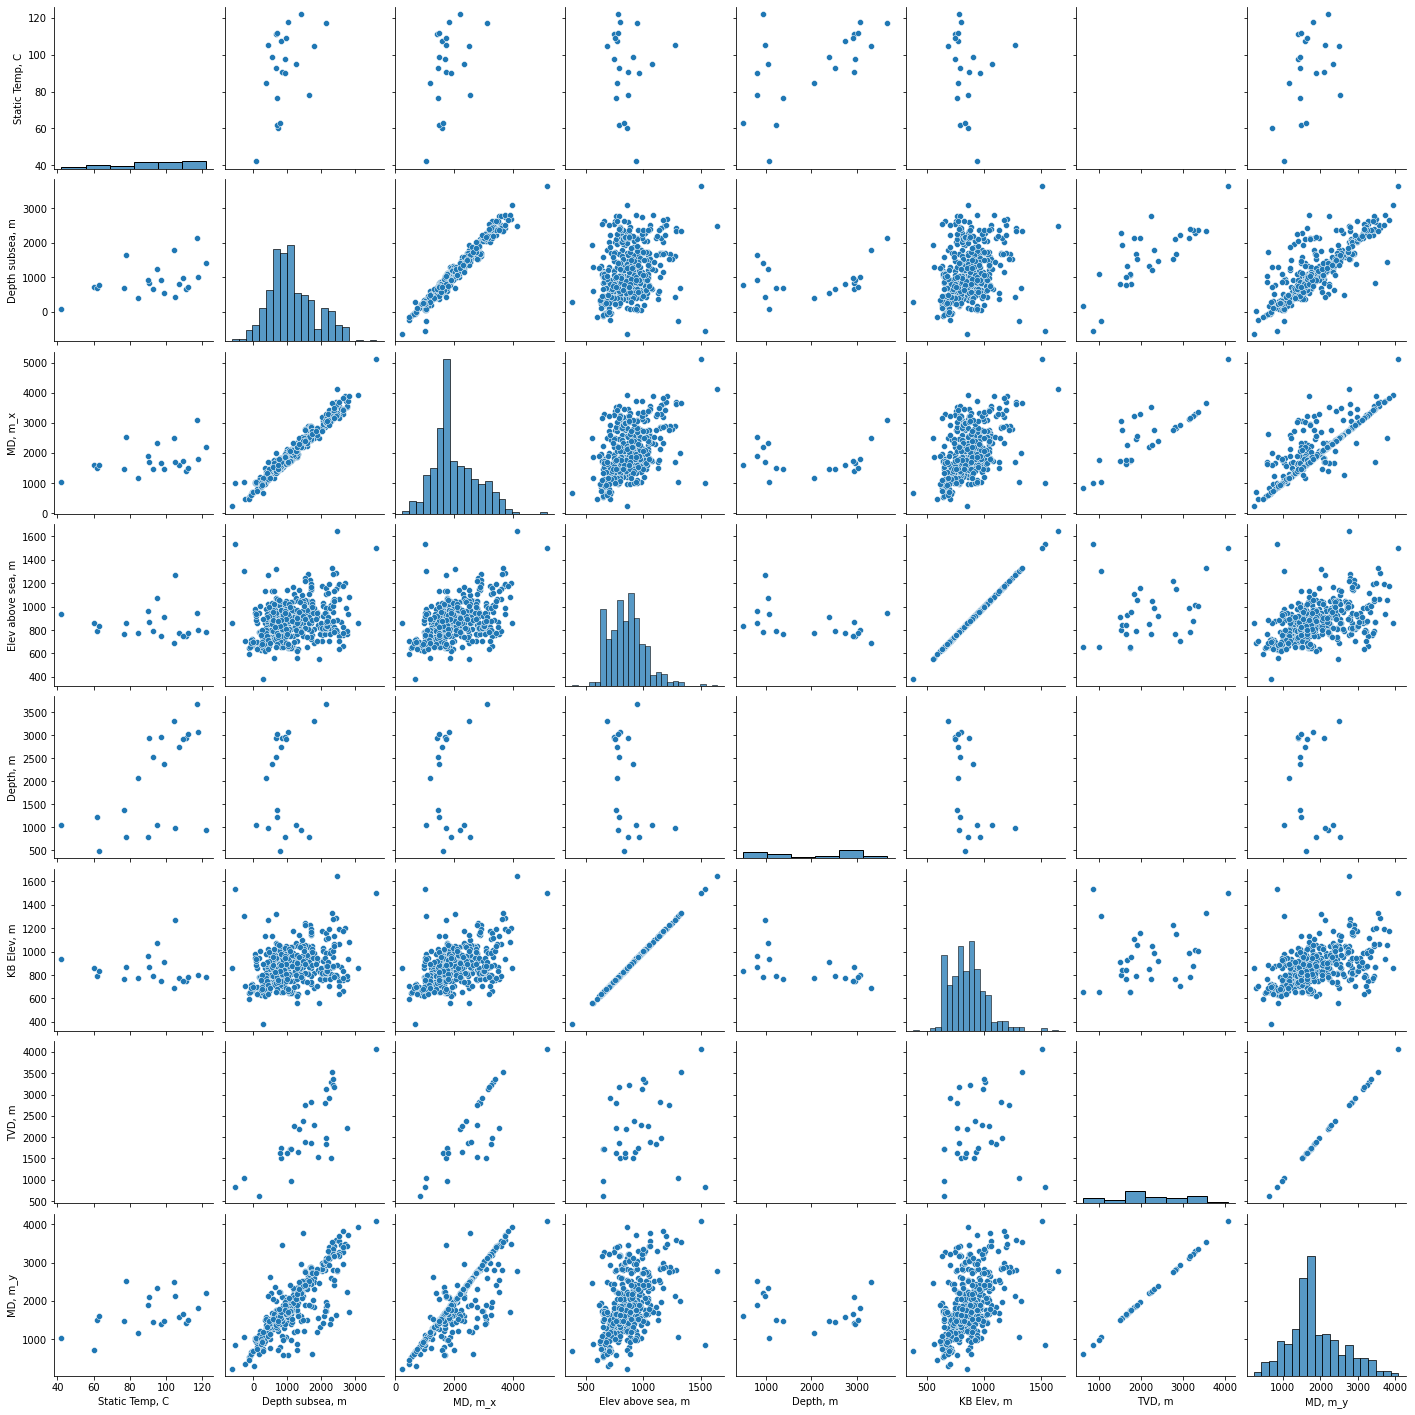

In [71]:
sns.pairplot(DVm[[ 'Static Temp, C',
            'Depth subsea, m',
            'MD, m_x',
            'Elev above sea, m',
            'Depth, m',
            'KB Elev, m',
            'TVD, m',
            'MD, m_y']])

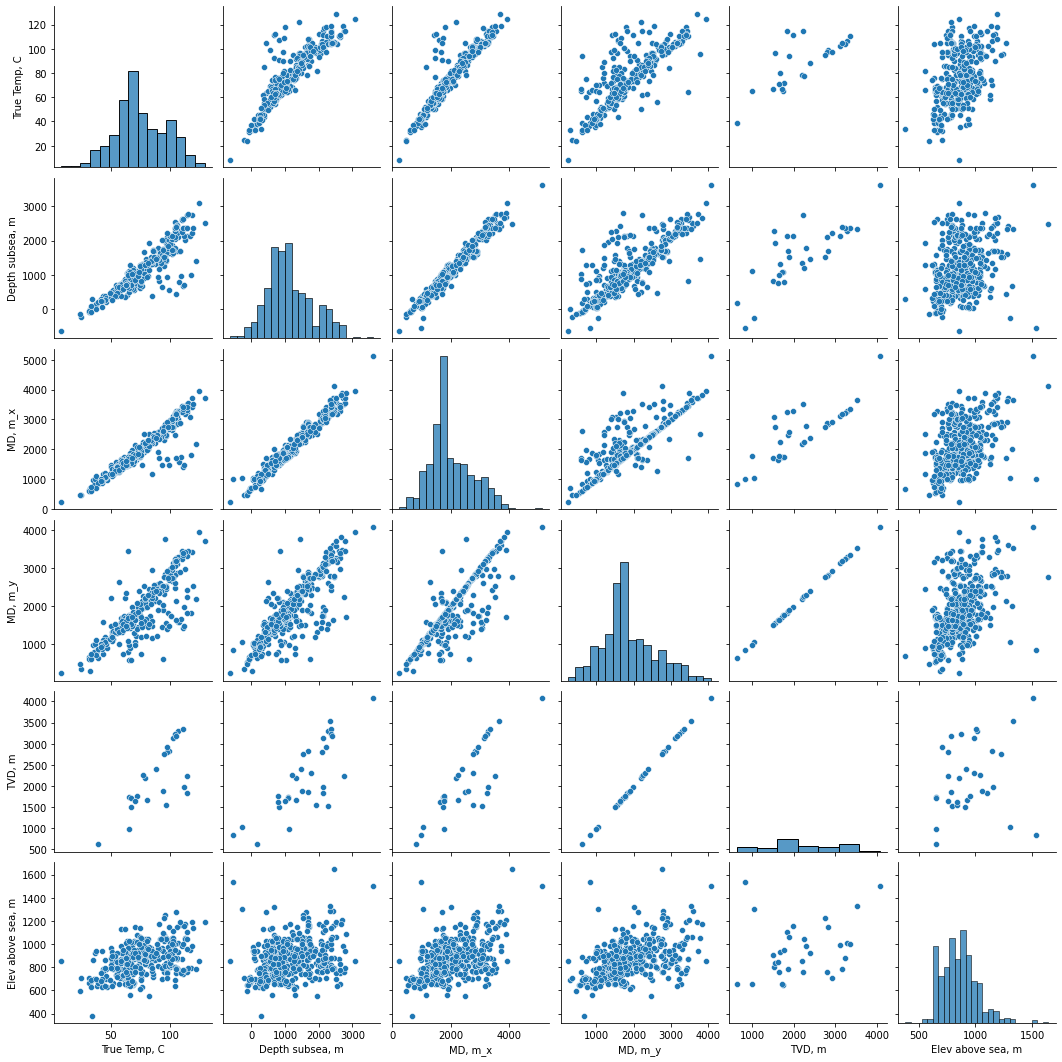

In [55]:
sns.pairplot(DVm[['True Temp, C','Depth subsea, m', 'MD, m_x', 'MD, m_y', 'TVD, m', 'Elev above sea, m']])